In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [10]:
from colorsetup import colors,palette
sns.set_palette(palette)

In [3]:
os.chdir('E:\Machine Learning Course\Course3\data')

In [4]:
df = pd.read_csv('./Human_Activity_Recognition_Using_Smartphones_Data.csv')

In [6]:
df.head(2)

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-skewness(),fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)",Activity
0,0.288585,-0.020294,-0.132905,-0.995279,-0.983111,-0.913526,-0.995112,-0.983185,-0.923527,-0.934724,...,-0.298676,-0.710304,-0.112754,0.030400,-0.464761,-0.018446,-0.841247,0.179941,-0.058627,STANDING
1,0.278419,-0.016411,-0.123520,-0.998245,-0.975300,-0.960322,-0.998807,-0.974914,-0.957686,-0.943068,...,-0.595051,-0.861499,0.053477,-0.007435,-0.732626,0.703511,-0.844788,0.180289,-0.054317,STANDING


In [7]:
df.shape

(10299, 562)

In [8]:
df.dtypes.value_counts()

float64    561
object       1
dtype: int64

In [11]:
feature_cols = df.dtypes==np.float

In [12]:
print((df.loc[:,feature_cols].max()==1.0).all())

True


In [13]:
print((df.loc[:,feature_cols].min()==-1.0).all())

True


In [15]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
df['Activity'] = le.fit_transform(df['Activity'])
le.classes_

array(['LAYING', 'SITTING', 'STANDING', 'WALKING', 'WALKING_DOWNSTAIRS',
       'WALKING_UPSTAIRS'], dtype=object)

In [17]:
df.Activity.unique()

array([2, 1, 0, 3, 4, 5])

In [18]:
df.Activity.value_counts(normalize=True)

0    0.188756
2    0.185067
1    0.172541
3    0.167201
5    0.149917
4    0.136518
Name: Activity, dtype: float64

In [19]:
from sklearn.model_selection import train_test_split

feature_cols = [x for x in df if x!='Activity']

X_train,X_test,y_train,y_test = train_test_split(df[feature_cols],df['Activity'],test_size=0.3,random_state=42)

X_train.shape,X_test.shape,y_train.shape,y_test.shape

((7209, 561), (3090, 561), (7209,), (3090,))

In [20]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score

error_list = list()

tree_list = [15,25,50,100,200,400]

for n_tree in tree_list:
    
    GBC = GradientBoostingClassifier(max_features=5,n_estimators=n_tree,random_state=42)
    
    print(f'fitting model with {n_tree} trees')
    
    GBC = GBC.fit(X_train,y_train)
    y_pred = GBC.predict(X_test)
    
    error = 1 - accuracy_score(y_test,y_pred)
    
    error_list.append(pd.Series({'n_tree':n_tree,'error':error}))
    
error_df = pd.concat(error_list,axis=1).T.set_index('n_tree')

error_df

fitting model with 15 trees
fitting model with 25 trees
fitting model with 50 trees
fitting model with 100 trees
fitting model with 200 trees
fitting model with 400 trees


,error
n_tree,
15.0,0.104854
25.0,0.072492
50.0,0.040129
100.0,0.024595
200.0,0.015210
400.0,0.014239


[Text(0.5, 0, 'Number of trees'), Text(0, 0.5, 'Error')]

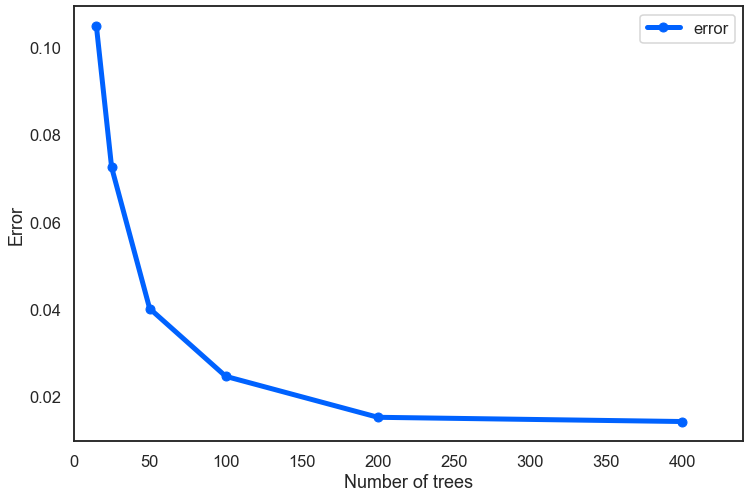

In [21]:
sns.set_context('talk')
sns.set_style('white')
sns.set_palette(palette)

ax = error_df.plot(marker='o',figsize=(12,8),linewidth=5)

ax.set_xlim(0,max(error_df.index)*1.1)
ax.set(xlabel='Number of trees',ylabel='Error')

In [22]:
from sklearn.model_selection import GridSearchCV

param_grid = {'learning_rate':[0.1,0.01,0.001],
              'subsample':[1.0,0.5],
              'max_features':[2,3,4]}

GV_GBC = GridSearchCV(GradientBoostingClassifier(n_estimators=400,random_state=42),param_grid=param_grid,scoring='accuracy',
                      n_jobs=-1)

GV_GBC = GV_GBC.fit(X_train,y_train)

In [24]:
GV_GBC.best_estimator_.learning_rate

0.1

In [26]:
from sklearn.metrics import classification_report

y_pred = GV_GBC.predict(X_test)
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       597
           1       0.97      0.96      0.97       563
           2       0.97      0.97      0.97       547
           3       1.00      1.00      1.00       539
           4       1.00      0.99      0.99       420
           5       0.99      0.99      0.99       424

    accuracy                           0.99      3090
   macro avg       0.99      0.99      0.99      3090
weighted avg       0.99      0.99      0.99      3090



<AxesSubplot:>

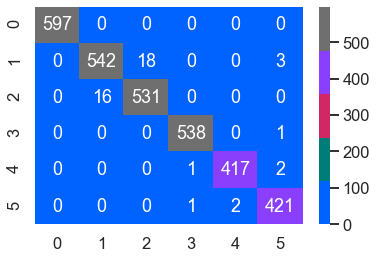

In [27]:
from sklearn.metrics import confusion_matrix

sns.set_context('talk')
cn = confusion_matrix(y_test,y_pred)
sns.heatmap(cn,annot=True,fmt='d',cmap=colors)

In [28]:
from sklearn.linear_model import LogisticRegression

lr_l2 = LogisticRegression(penalty='l2',solver='saga',max_iter=500).fit(X_train,y_train)

In [29]:
y_pred = lr_l2.predict(X_test)
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       597
           1       0.96      0.95      0.95       563
           2       0.95      0.95      0.95       547
           3       0.99      1.00      0.99       539
           4       1.00      0.98      0.99       420
           5       0.98      1.00      0.99       424

    accuracy                           0.98      3090
   macro avg       0.98      0.98      0.98      3090
weighted avg       0.98      0.98      0.98      3090



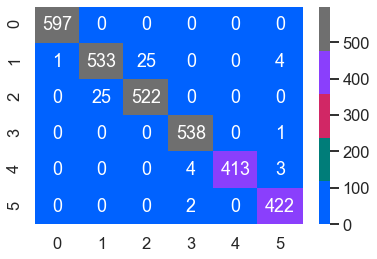

In [30]:
sns.set_context('talk')
cm = confusion_matrix(y_test,y_pred)
ax = sns.heatmap(cm,fmt='d',annot=True,cmap=colors)

In [31]:
from sklearn.ensemble import VotingClassifier

estimator = [('lr_l2',lr_l2),('GV_GBC',GV_GBC)]

VC = VotingClassifier(estimator,voting='soft')
VC = VC.fit(X_train,y_train)

In [32]:
y_pred = VC.predict(X_test)
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       597
           1       0.97      0.96      0.97       563
           2       0.97      0.97      0.97       547
           3       1.00      1.00      1.00       539
           4       1.00      0.99      1.00       420
           5       0.98      1.00      0.99       424

    accuracy                           0.99      3090
   macro avg       0.99      0.99      0.99      3090
weighted avg       0.99      0.99      0.99      3090



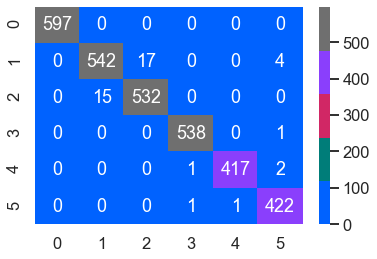

In [33]:
sns.set_context('talk')
cm = confusion_matrix(y_test,y_pred)
ax = sns.heatmap(cm,annot=True,fmt='d',cmap=colors)